In [1]:
from pathlib import Path
import sys
import os
path_root = Path(os.getcwd()).parents[1]
sys.path.append(str(path_root))

In [2]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

In [3]:
with open('../../outputs/gpt/train_metrics.pickle', 'rb') as f:
    training_metrics = pickle.load(f)

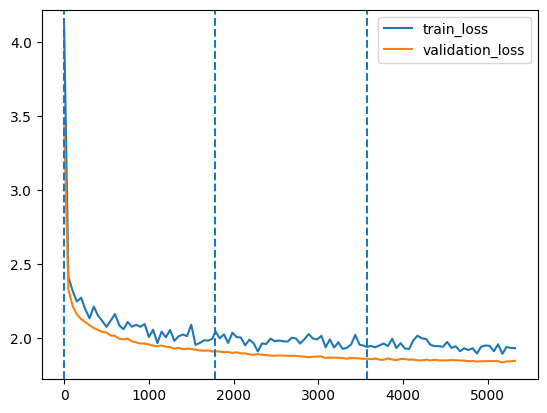

In [4]:
plt.plot(*list(zip(*[(m['global_step'], m['train_loss']) for m in training_metrics])), label='train_loss')
plt.plot(*list(zip(*[(m['global_step'], m['validation_loss']) for m in training_metrics])), label='validation_loss')
for point in [m['global_step'] for i, m in enumerate(training_metrics) if training_metrics[i-1]['epoch'] != m['epoch']]:
    plt.axvline(x=point, linestyle='--')
plt.legend()
plt.show()

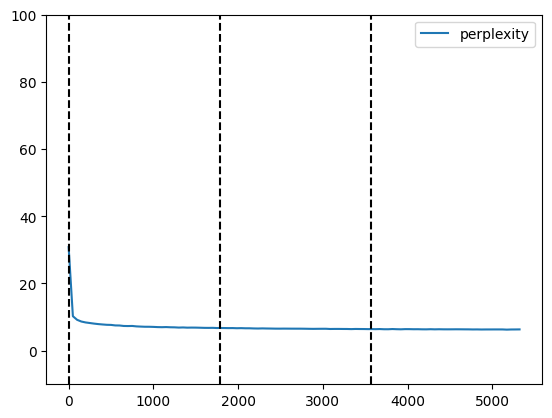

In [5]:
plt.plot(*list(zip(*[(m['global_step'], m['perplexity']) for m in training_metrics])), label='perplexity')
for point in [m['global_step'] for i, m in enumerate(training_metrics) if training_metrics[i-1]['epoch'] != m['epoch']]:
    plt.axvline(x=point, linestyle='--', c='black')
plt.ylim(top=100, bottom=-10)
plt.legend()
plt.show()

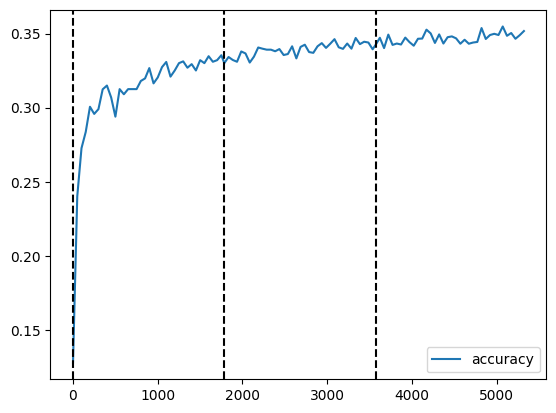

In [6]:
plt.plot(*list(zip(*[(m['global_step'], m['accuracy'].item()) for m in training_metrics])), label='accuracy')# plt.plot(*list(zip(*[(m['global_step'], m['perplexity'].item()) for m in training_metrics])), label='perplexity')
for point in [m['global_step'] for i, m in enumerate(training_metrics) if training_metrics[i-1]['epoch'] != m['epoch']]:
    plt.axvline(x=point, linestyle='--', c='black')
plt.legend()
plt.show()

In [7]:
min([m['validation_loss'] for m in training_metrics])

1.8346461057662964

# Final Evaluation Outputs

In [8]:
food_names = np.load('../../../data/local/final/full/food_names/0.npy', allow_pickle=True)
food_names.shape

(1110,)

In [9]:
input = training_metrics[-1]['input']
output = training_metrics[-1]['output']

In [10]:
pd.set_option('max_colwidth', None)

In [11]:
input[1].shape

torch.Size([1000, 13])

In [12]:
pd.DataFrame({
    'input': food_names[input[0]].tolist(), 
    'label': food_names[input[1]].tolist(),
    'prediction': food_names[output.argmax(2)].tolist(), 
})

,input,label,prediction
0,"[gelatin, water, yogurt, sugar, vanilla, cardamom, sweet orange, cinnamon, <end>, <pad>, <pad>, <pad>, <pad>]","[water, yogurt, sugar, vanilla, cardamom, sweet orange, cinnamon, <end>, <pad>, <pad>, <pad>, <pad>, <pad>]","[water, sugar, sugar, vanilla, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"
1,"[egg roll, sugar, pudding, cinnamon, margarine, nut, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[sugar, pudding, cinnamon, margarine, nut, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[cheese, cinnamon, cinnamon, butter, nut, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"
2,"[cracker, butter, sugar, flour, sauce, water, cocoa powder, salt, potato chip, marshmallow, <end>, <pad>, <pad>]","[butter, sugar, flour, sauce, water, cocoa powder, salt, potato chip, marshmallow, <end>, <pad>, <pad>, <pad>]","[butter, sugar, cheese, cheese, cheese, salt, salt, egg, <end>, <end>, <end>, milk cow, milk cow]"
3,"[coffee, almond, curry powder, sugar substitute, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[almond, curry powder, sugar substitute, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[sugar, sugar, water, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"
4,"[pie crust, spinach, egg, onion-family vegetable, nutmeg, crab, cheese, evaporated milk, salt, pepper, parsley, <end>, <pad>]","[spinach, egg, onion-family vegetable, nutmeg, crab, cheese, evaporated milk, salt, pepper, parsley, <end>, <pad>, <pad>]","[cheese, cheese, cheese, cheese, salt, cheese, <end>, <end>, pepper, <end>, <end>, <end>, <end>]"
...,...,...,...
995,"[meat bouillon, onion-family vegetable, green turtle, sauce, garlic, green bean, rice, cheese, tortilla, <end>, <pad>, <pad>, <pad>]","[onion-family vegetable, green turtle, sauce, garlic, green bean, rice, cheese, tortilla, <end>, <pad>, <pad>, <pad>, <pad>]","[onion-family vegetable, garlic, garden tomato, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"
996,"[chicken, sauce, walnut, sweet orange, <unknown>, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[sauce, walnut, sweet orange, <unknown>, <end>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>, <pad>]","[onion-family vegetable, cheese, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"
997,"[egg, cream, buttermilk, honey, curry powder, water, salt, flour, butter, vanilla, domestic pig, syrup, <end>]","[cream, buttermilk, honey, curry powder, water, salt, flour, butter, vanilla, domestic pig, syrup, <end>, <pad>]","[sugar, sugar, salt, salt, salt, salt, pepper, <end>, <end>, <end>, <end>, <end>, <end>]"
998,"[butter, flour, curry powder, salt, sugar, egg, vanilla, milk cow, chocolate, <end>, <pad>, <pad>, <pad>]","[flour, curry powder, salt, sugar, egg, vanilla, milk cow, chocolate, <end>, <pad>, <pad>, <pad>, <pad>]","[sugar, sugar, salt, sugar, egg, vanilla, <end>, <end>, <end>, <end>, <end>, <end>, <end>]"


This way of evaluating the model is wrong. There are repeated predicted tokens here because it is predicting from the input, and the most probable token hasn't yet appeared in the input.

We need to evaluate the model by simply looking at generations that it does.

In [43]:
from recipe_generator.models.gpt import GPTLanguageModel
from recipe_generator.models.gpt import Config

food_vectors = torch.tensor(np.load('../../../data/local/final/full/food_compounds/0.npy'), dtype=torch.float) #TODO: unnecessary dependancy
model = GPTLanguageModel(Config.from_json('../../config/gpt_base.json'), food_vectors)

model.load_state_dict(torch.load('../../outputs/gpt/model.pt'))
model.to('cuda');
model.eval();

In [44]:
np.argwhere(food_names=='chicken')

array([[418]])

In [45]:
context = (torch.ones((5,1), dtype=torch.long)*418).to('cuda')
context

tensor([[418],
        [418],
        [418],
        [418],
        [418]], device='cuda:0')

In [47]:
generations = model.generate(context, 14).to('cpu')
food_names[generations]

array([['chicken', 'sauce', 'olive oil', 'sweet orange', 'sweet basil',
        '<end>', 'mushroom', 'carrot', 'celery stalk', '<end>', 'lemon',
        'ketchup', 'cucumber', 'cheese', 'olive'],
       ['chicken', 'salt', 'sugar', 'oil palm', 'flour', 'vinegar',
        'egg', 'soy sauce', 'ginger', 'green turtle', '<end>',
        'celery stalk', 'green onion', 'almond', '<end>'],
       ['chicken', 'chicken', 'cabbage', 'soup', 'flour', 'green onion',
        '<end>', 'butter', 'milk cow', '<end>', 'potato', 'carrot',
        'pepper spice', 'cream', '<unknown>'],
       ['chicken', 'cheese', 'bread', 'butter', '<end>', '<end>',
        'garden tomato', 'mushroom', 'vinegar', 'mustard',
        'curry powder', '<end>', '<end>', 'onion-family vegetable',
        'garlic'],
       ['chicken', 'sauce', 'salad dressing', 'green onion', '<end>',
        'egg', 'cream', 'edible shell', 'water', '<end>', '<end>',
        'broccoli', 'cheese', 'domestic pig', 'carrot']], dtype=object)